<a href="https://colab.research.google.com/github/antoinemarchal/FFT-21cm/blob/main/Marchal_et_al_2022b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mapping a lower limit on the mass fraction of the cold neutral medium using Fourier transformed HI 21cm emission line spectra



In [ ]:
!pip install ROHSApy
!pip install marchalib -U
!pip install fBms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 66.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynverse: filename=pynverse-0.1.4.4-py3-none-any.whl size=6348 sha256=c96da258f63e0b4f115357a9bcd777706e73d65271180fd836048399512ce739
  Stored in directory: /root/.cache/pip/wheels/42/d4/98/c957a0dc68d88ace74b11435dae2b4fa55bfb1342a4e6b551b
Successfully built pynverse
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_UMAEAST_Tb.fits

--2023-05-17 21:18:34--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_UMAEAST_Tb.fits
Resolving www.cita.utoronto.ca (www.cita.utoronto.ca)... 128.100.76.81
Connecting to www.cita.utoronto.ca (www.cita.utoronto.ca)|128.100.76.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67394880 (64M)
Saving to: ‘GHIGLS_UMAEAST_Tb.fits’

GHIGLS_UMAEAST_Tb.f 100%[===================>]  64.27M  49.1MB/s    in 1.3s    

2023-05-17 21:18:38 (49.1 MB/s) - ‘GHIGLS_UMAEAST_Tb.fits’ saved [67394880/67394880]



In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.fft import rfftn

from ROHSApy import ROHSA
import marchalib as ml

name = "UMAEAST"
fitsname = "GHIGLS_" + name + "_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
data = hdu[0].data[0]
core = ROHSA(data, hdr)

In [ ]:
#Get sub velocity range
v = core.v
dv = np.abs(hdr["CDELT3"]*1.e-3)
vmin = -20
vmax = 20
idvmax = np.where((v > vmin) & (v < vmax))[0][::-1][0]
idvmin = np.where((v > vmin) & (v < vmax))[0][0]

subv = v[idvmin:idvmax]
cube = data[idvmin:idvmax]

NHI = np.sum(cube,0) * dv * 1.82243e+18 / 1.e19

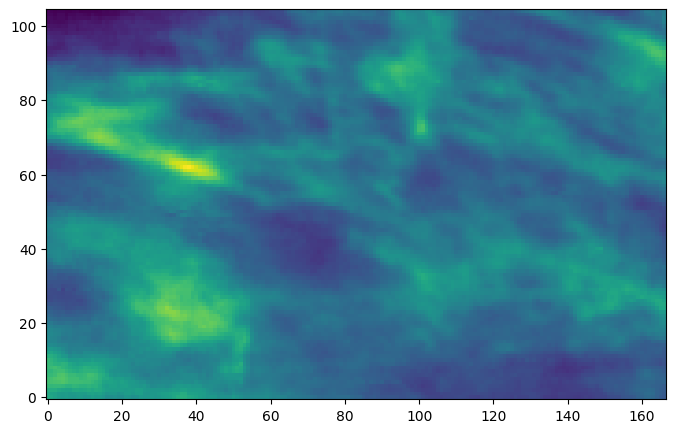

In [ ]:
#Plot total column density map
plt.figure(figsize=(8,8))
plt.imshow(NHI, origin="lower", cmap="viridis")

In [ ]:
#Fourier all cube along v axis
hfreqs = np.fft.rfftfreq(cube.shape[0], dv)

hsfft = np.zeros((len(hfreqs),cube.shape[1],cube.shape[2]))
for i in tqdm(np.arange(cube.shape[1])):
    for j in np.arange(cube.shape[2]):
        s = cube[:,i,j]
        #Apodization
        tapper = ml.apodize_1d(0.9,len(s))
        s_apod = s * tapper
        hsfft[:,i,j] = np.abs(rfftn(s_apod))
        #Normalization by total NHI (FFT at k=0)
        hsfft[:,i,j] /= hsfft[0,i,j]

#Selected kv cut (see paper)
kcut = 0.12

100%|██████████| 105/105 [00:01<00:00, 56.77it/s]


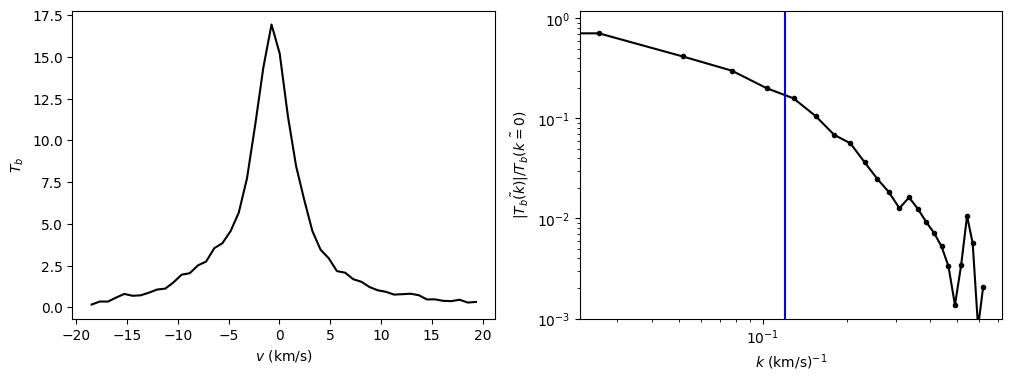

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
x = 40; y = 65
ax1.plot(subv, cube[:,x,y], "-k")
ax1.set_ylabel(r"$T_b$")
ax1.set_xlabel(r"$v$ (km/s)")
ax2.plot(hfreqs, hsfft[:,x,y], ".-k")
ax2.plot([kcut, kcut], [0,2], "-b")
ax2.set_ylim([1.e-3,1.2])
ax2.set_ylabel(r"|$\tilde{T_b(k)}$|/$\tilde{T_b(k=0)}$")
ax2.set_xlabel(r"$k$ (km/s)$^{-1}$")
ax2.set_xscale("log")
ax2.set_yscale("log")

In [ ]:
klim = np.where(np.sort(hfreqs) > kcut)[0][0]
print(klim, hfreqs[klim])
fcnm_low = np.max(hsfft[klim:],0)

5 0.12904266993877897


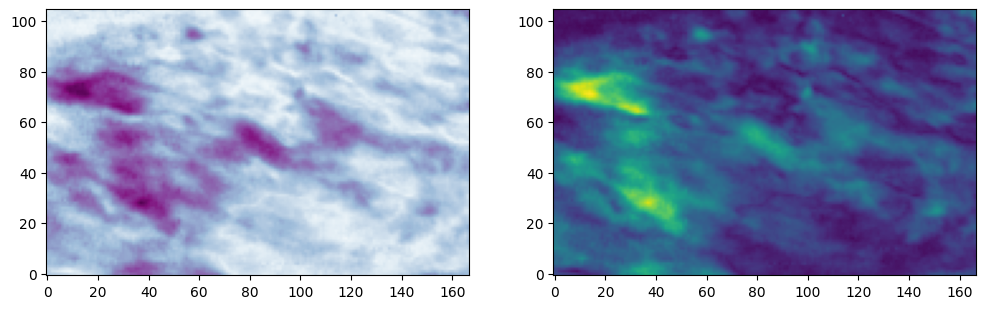

In [ ]:
#Plot mass fraction map
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.imshow(fcnm_low, origin="lower", vmin=0., vmax=0.3,
          cmap="BuPu")
ax2.imshow(fcnm_low*NHI, origin="lower", vmin=0.,
          cmap="viridis")